In [1]:
# !git clone https://github.com/CMU-Perceptual-Computing-Lab/panoptic-toolbox
# %cd panoptic-toolbox
# !./scripts/getData.sh 171204_pose1_sample
# !./scripts/extractAll.sh 171204_pose1_sample

In [2]:
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
# ------------------------------------------------------------------------------

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
import argparse
import os
import pprint
import logging
import json
import sys
import copy
import cv2

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)


# this_dir = osp.dirname(__file__)
this_dir = os.getcwd()

# lib_path = osp.join(this_dir, '..', 'lib')
lib_path = os.path.join(this_dir, 'lib')
add_path(lib_path)

In [3]:
from mmpose.core.evaluation import keypoints_from_heatmaps
import math
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [4]:
# import _init_paths
from core.config import config
from core.config import update_config
from core.function import train_3d, validate_3d
from utils.utils import create_logger
from utils.utils import save_checkpoint, load_checkpoint, load_model_state
from utils.utils import load_backbone_panoptic
import dataset
import models

/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


In [5]:
def parse_args(argstring):
    parser = argparse.ArgumentParser(description='Train keypoints network')
    parser.add_argument(
        '--cfg', help='experiment configure file name', required=True, type=str)

    args, rest = parser.parse_known_args(argstring)
    update_config(args.cfg)

    return args

In [6]:
%matplotlib inline

In [7]:
args = parse_args(['--cfg', 'configs/panoptic/resnet50/prn64_cpn80x80x20_960x512_cam5.yaml'])
#python run/train_3d.py --cfg configs/panoptic/resnet50/prn64_cpn80x80x20_960x512_cam5.yaml

In [10]:
gpus = [int(i) for i in config.GPUS.split(',')]
print('=> Loading data ..')
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

=> Loading data ..


In [11]:
config.TEST.BATCH_SIZE = 1

In [12]:
test_dataset = eval('dataset.' + config.DATASET.TEST_DATASET)(
    config, config.DATASET.TEST_SUBSET, False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.TEST.BATCH_SIZE * len(gpus),
    shuffle=True,
    num_workers=config.WORKERS,
    pin_memory=True)

In [13]:
cudnn.benchmark = config.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = config.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = config.CUDNN.ENABLED

In [14]:
config.BACKBONE_MODEL = 'pose_hrnet'

In [15]:
# config.BACKBONE_MODEL = 'pose_resnet'

In [16]:
print('=> Constructing models ..')
model = eval('models.' + config.MODEL + '.get_multi_person_pose_net')(
    config, is_train=True)
with torch.no_grad():
    model = torch.nn.DataParallel(model, device_ids=gpus).cuda()

final_output_dir = ""
    
test_model_file = os.path.join(final_output_dir, config.TEST.MODEL_FILE)

=> Constructing models ..
load checkpoint from local path: /workspace/voxelpose-pytorch/data/higher_hrnet48_coco_512x512-60fedcbc_20200712.pth


In [17]:
model.module.backbone

AssociativeEmbedding(
  (backbone): HRNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [18]:
test_model_file = '/workspace/voxelpose-pytorch/output_HRNET/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/inter-checkpoint.pth'
test_model_file = '/workspace/voxelpose-pytorch/output_HRNET_ASSO/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/inter-checkpoint_20000.pth'

test_model_file = '/workspace/voxelpose-pytorch/output_HRNET_ASSO/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5_AUGMENTATION/inter-checkpoint_20000.pth'
test_model_file = '/workspace/voxelpose-pytorch/output_HRNET_ASSO/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5_AUGMENTATION/inter-checkpoint.pth'
model.load_state_dict(torch.load(test_model_file), strict=True)
# model.module.load_state_dict(torch.load(test_model_file), strict=True)

<All keys matched successfully>

In [19]:
# test_model_file = '/workspace/voxelpose-pytorch/output/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/model_best.pth.tar'
# test_model_file = '/workspace/voxelpose-pytorch/output_alldata/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/model_best.pth.tar'
# model.module.load_state_dict(torch.load(test_model_file), strict=True)

In [20]:
# test_model_file = '/workspace/voxelpose-pytorch/output/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/checkpoint.pth.tar'
# model.module.load_state_dict(torch.load(test_model_file)['state_dict'], strict=True)

In [21]:
# validate_3d(config, model, test_loader, final_output_dir)

In [22]:
model.eval()

DataParallel(
  (module): MultiPersonPoseNet(
    (backbone): AssociativeEmbedding(
      (backbone): HRNet(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, ker

In [23]:
# with torch.no_grad():
#     for i, (inputs, targets_2d, weights_2d, targets_3d, meta, input_heatmap) in enumerate(test_loader):
#         if 'panoptic' in config.DATASET.TEST_DATASET:
#             preds, heatmaps, grid_centers, _, _, _ = model(views=inputs, meta=meta, targets_2d=None,
#                                                       weights_2d=None, targets_3d=None)
#         print(i)
#         break

In [24]:
from utils.transforms import affine_transform, get_scale, get_affine_transform

In [25]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [26]:
transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

In [27]:
def get_P(meta, _cam_idx, _target_batch_idx):
    R = meta[_cam_idx]['camera']['R'][_target_batch_idx].numpy()
    T = meta[_cam_idx]['camera']['T'][_target_batch_idx].numpy()
    fx = meta[_cam_idx]['camera']['fx'][_target_batch_idx].numpy()
    fy = meta[_cam_idx]['camera']['fy'][_target_batch_idx].numpy()
    cx = meta[_cam_idx]['camera']['cx'][_target_batch_idx].numpy()
    cy = meta[_cam_idx]['camera']['cy'][_target_batch_idx].numpy()
    K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])
    
    T_cam = -np.matmul(R, T)
    
    RT = np.concatenate((R,T_cam),axis=1)
    P = np.matmul(K, RT)
    return P

In [28]:
def make_meta(_data_i):
    
    z_offset = 0.
#     fx = 960.
#     fy = 960.

#     fx = 1333.33 # blender focal length 25mm.
#     fy = 1333.33
    
    fx = 533.33 # blender focal length 10mm.
    fy = 533.33
    
    meta_empty = {
    "image" : None, # image path
    'num_person' : torch.tensor([0]),
    'joints_3d' : torch.zeros([1, 10, 15, 3], dtype=torch.float64),
    'joints_3d_vis' : torch.zeros([1, 10, 15, 3], dtype=torch.float64),
    'roots_3d' : torch.zeros([1, 10, 3], dtype=torch.float64), 
    'joints' : torch.zeros([1, 10, 15, 2], dtype=torch.float64),
    'joints_vis' : torch.zeros([1, 10, 15, 2], dtype=torch.float64),
    'center' : torch.tensor([[960., 540.]], dtype=torch.float64),
    'scale' : torch.tensor([[10.1250,  5.4000]]),
    'rotation' : torch.tensor([0]),
    'camera' : None,
    'rot_aug_Rz' : np.zeros(1)
    }
    
    meta_0 = copy.copy(meta_empty)
    meta_0['image'] = ['/datasets/synthetic_panoptic/cam00/%04d.png'%_data_i]
    meta_0['camera'] = {
    'R': torch.tensor([[[-0.62290078,  0.78179181,  0.02822398],
     [ 0.07520963,  0.09575719, -0.99255949],
     [-0.7786774,  -0.61614317, -0.1184453 ]]], dtype=torch.float64),
     'T': torch.tensor([[[2074.90595409],
              [1783.55456846],
              [1511.40832102 + z_offset]]], dtype=torch.float64),
     'fx': torch.tensor([fx], dtype=torch.float64),
     'fy': torch.tensor([fy], dtype=torch.float64),
     'cx': torch.tensor([960.0], dtype=torch.float64),
     'cy': torch.tensor([540.0], dtype=torch.float64),
     'k': torch.tensor([[[0.0],
              [ 0.0],
              [0.0]]], dtype=torch.float64),
     'p': torch.tensor([[[0.0],
              [ 0.0]]], dtype=torch.float64)
    }
    
    meta_1 = copy.copy(meta_empty)
    meta_1['image'] = ['/datasets/synthetic_panoptic/cam01/%04d.png'%_data_i]
    meta_1['camera'] = {
    'R': torch.tensor([[[ 0.94556433, -0.3218047 ,  0.04847517],
     [-0.21279474, -0.72408485, -0.65606368],
     [ 0.24622451,  0.61003518, -0.75314713]]], dtype=torch.float64),
     'T': torch.tensor([[[-664.98871654],
              [-1728.44849274],
              [3398.18015007 + z_offset]]], dtype=torch.float64),
     'fx': torch.tensor([fx], dtype=torch.float64),
     'fy': torch.tensor([fy], dtype=torch.float64),
     'cx': torch.tensor([960.0], dtype=torch.float64),
     'cy': torch.tensor([540.0], dtype=torch.float64),
     'k': torch.tensor([[[0.0],
              [ 0.0],
              [0.0]]], dtype=torch.float64),
     'p': torch.tensor([[[0.0],
              [ 0.0]]], dtype=torch.float64)
    }
    
    meta_2 = copy.copy(meta_empty)
    meta_2['image'] = ['/datasets/synthetic_panoptic/cam02/%04d.png'%_data_i]
    meta_2['camera'] = {
    'R': torch.tensor([[[-0.99504423, -0.08979495, -0.04270841],
     [-0.00280686,  0.45470917, -0.89063561],
     [ 0.09939449, -0.8861019,  -0.45270765]]], dtype=torch.float64),
     'T': torch.tensor([[[-97.52239051],
              [2539.71154223],
              [2394.18234902 + z_offset]]], dtype=torch.float64),
     'fx': torch.tensor([fx], dtype=torch.float64),
     'fy': torch.tensor([fy], dtype=torch.float64),
     'cx': torch.tensor([960.0], dtype=torch.float64),
     'cy': torch.tensor([540.0], dtype=torch.float64),
     'k': torch.tensor([[[0.0],
              [ 0.0],
              [0.0]]], dtype=torch.float64),
     'p': torch.tensor([[[0.0],
              [ 0.0]]], dtype=torch.float64)
    }
    
    meta_3 = copy.copy(meta_empty)
    meta_3['image'] = ['/datasets/synthetic_panoptic/cam03/%04d.png'%_data_i]
    meta_3['camera'] = {
    'R': torch.tensor([[[-0.28573981, -0.9554829,  -0.07351949],
     [-0.75703084,  0.27209935, -0.59402543],
     [ 0.58758575, -0.11408021, -0.80107969]]], dtype=torch.float64),
     'T': torch.tensor([[[-1842.40268394],
              [112.16023584],
              [3394.71695096 + z_offset]]], dtype=torch.float64),
     'fx': torch.tensor([fx], dtype=torch.float64),
     'fy': torch.tensor([fy], dtype=torch.float64),
     'cx': torch.tensor([960.0], dtype=torch.float64),
     'cy': torch.tensor([540.0], dtype=torch.float64),
     'k': torch.tensor([[[0.0],
              [ 0.0],
              [0.0]]], dtype=torch.float64),
     'p': torch.tensor([[[0.0],
              [ 0.0]]], dtype=torch.float64)
    }
    
    meta_4 = copy.copy(meta_empty)
    meta_4['image'] = ['/datasets/synthetic_panoptic/cam04/%04d.png'%_data_i]
    meta_4['camera'] = {
    'R': torch.tensor([[[ 0.51438838,  0.85744053, -0.01415454],
     [ 0.14237219, -0.10166404, -0.98457837],
     [-0.84565639,  0.50444043, -0.1743705 ]]], dtype=torch.float64),
     'T': torch.tensor([[[2359.22574983],
              [-1432.84771683],
              [1527.21982541 + z_offset]]], dtype=torch.float64),
     'fx': torch.tensor([fx], dtype=torch.float64),
     'fy': torch.tensor([fy], dtype=torch.float64),
     'cx': torch.tensor([960.0], dtype=torch.float64),
     'cy': torch.tensor([540.0], dtype=torch.float64),
     'k': torch.tensor([[[0.0],
              [ 0.0],
              [0.0]]], dtype=torch.float64),
     'p': torch.tensor([[[0.0],
              [ 0.0]]], dtype=torch.float64)
    }
    
    _meta_new = []
    _meta_new.append(meta_0)
    _meta_new.append(meta_1)
    _meta_new.append(meta_2)
    _meta_new.append(meta_3)
    _meta_new.append(meta_4)
    
    return _meta_new


In [29]:
def make_inputs(num_cam, _data_i):
    _inputs_new = []

    for i in range(num_cam):

        data_numpy = cv2.imread('/datasets/synthetic_panoptic/cam%02d/'%i+'%04d.png'%_data_i)
        data_numpy = cv2.cvtColor(data_numpy, cv2.COLOR_BGR2RGB)
        height, width, _ = data_numpy.shape
        c = np.array([width / 2.0, height / 2.0])
        s = get_scale((width, height), [960,512])
        r = 0
        trans = get_affine_transform(c, s, r, [960,512])

        input = cv2.warpAffine(
                    data_numpy,
                    trans, (int(960), int(512)),
                    flags=cv2.INTER_LINEAR)
        input = transform(input)

        input = input.unsqueeze(0)

        _inputs_new.append(input)
        
    return _inputs_new

In [30]:
# experiment : focal length dependency

# def make_inputs(num_cam, _data_i):
#     _inputs_new = []

#     for i in range(num_cam):

#         data_numpy = cv2.imread('/datasets/synthetic_panoptic/cam%02d/'%i+'%04d.png'%_data_i)
#         data_numpy = cv2.cvtColor(data_numpy, cv2.COLOR_BGR2RGB)
        
#         data_numpy = data_numpy[540-216:540+216, 960-384:960+384, :] # crop
#         data_numpy = cv2.resize(data_numpy, (1920,1080)) # resize
        
        
#         height, width, _ = data_numpy.shape
#         c = np.array([width / 2.0, height / 2.0])
#         s = get_scale((width, height), [960,512])
#         r = 0
#         trans = get_affine_transform(c, s, r, [960,512])

#         input = cv2.warpAffine(
#                     data_numpy,
#                     trans, (int(960), int(512)),
#                     flags=cv2.INTER_LINEAR)
#         input = transform(input)

#         input = input.unsqueeze(0)

#         _inputs_new.append(input)
        
#     return _inputs_new

In [31]:
batch_size = 1

In [32]:
# pixel std is 200.0
x = 0
y = 0
w = 960
h = 512

w = 1920
h = 1080

# w = 512
# h = 512

# input_size = cfg.data_cfg['image_size']
# aspect_ratio = input_size[0] / input_size[1]
# aspect_ratio = 288 / 384
center = np.array([x + w * 0.5, y + h * 0.5], dtype=np.float32)

# if w > aspect_ratio * h:
#     h = w * 1.0 / aspect_ratio
# elif w < aspect_ratio * h:
#     w = h * aspect_ratio

scale = np.array([w / 200.0, h / 200.0], dtype=np.float32)
# scale = scale * 1.25

# scale = np.array([max(w / 200.0, h / 200.0), max(w / 200.0, h / 200.0)], dtype=np.float32)

batch_scale = np.zeros((batch_size, 2))
batch_center = np.zeros((batch_size, 2))
batch_scale[:] = scale
batch_center[:] = center

In [33]:
with torch.no_grad():
    
    for data_i in range(180):
        print(data_i)
        meta_new = make_meta(data_i)
        num_view = len(meta_new)
        inputs_new = make_inputs(num_view, data_i)
    
        preds, heatmaps, grid_centers, _, _, _ = model(views=inputs_new, meta=meta_new, targets_2d=None,
                                                      weights_2d=None, targets_3d=None)


        target_batch_idx = 0
        preds_np = preds.detach().cpu().numpy()
        one_pred = preds_np[target_batch_idx]
        detected_idx = one_pred[:, 0, 3] == 0
        num_detected = sum(detected_idx)
        print('num_detected is : {}'.format(num_detected))

        pred_joint_color = [0, 0, 255]
        GT_joint_color = [0, 255, 0]

        output_holder = []
        heatmap_holder = []
        
        for camera_i in range(len(inputs_new)):
            image_cam = cv2.imread(meta_new[camera_i]['image'][0])
            for cand in range(num_detected):
                joint_3d = one_pred[cand, :, :3]
            #     joint_3d /= 1000.

                ones = np.ones((joint_3d.shape[0],1))
                joint_3d_homo = np.concatenate((joint_3d, ones), axis=1)

                P = get_P(meta_new, camera_i, target_batch_idx) # meta, cam_idx, batch_idx , [3,4]

                projected = np.matmul(P, joint_3d_homo.T).T
                projected /= projected[:,2:3]

                for joint in range(joint_3d.shape[0]):
                    image_cam = cv2.circle(image_cam, (int(projected[joint,0]),int(projected[joint,1])), 0, pred_joint_color, 10)
                    

            reds, maxvals = keypoints_from_heatmaps(heatmaps[camera_i].detach().cpu().numpy(), center=batch_center, scale=batch_scale)
            heatmap_fig = np.sum(heatmaps[camera_i][0].detach().cpu().numpy(), axis=0)
            backtorgb = cv2.applyColorMap(np.uint8(255 * heatmap_fig), cv2.COLORMAP_JET)
            
            
            image_cam = cv2.resize(image_cam, (480, 256))
            
            output_holder.append(image_cam)
            heatmap_holder.append(backtorgb)

        hconcat_rgb = cv2.hconcat(output_holder)
        hconcat_heatmap = cv2.hconcat(heatmap_holder)
        
        concat = cv2.vconcat([hconcat_rgb, hconcat_heatmap])
        
        cv2.imwrite('/datasets/synthetic_panoptic/debug/%04d.png'%data_i, concat)
        output_holder = []



0


/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


num_detected is : 3
1
num_detected is : 3
2
num_detected is : 3
3
num_detected is : 3
4
num_detected is : 3
5
num_detected is : 3
6
num_detected is : 3
7
num_detected is : 3
8
num_detected is : 2
9
num_detected is : 2
10
num_detected is : 2
11
num_detected is : 2
12
num_detected is : 2
13
num_detected is : 2
14
num_detected is : 2
15
num_detected is : 2
16
num_detected is : 2
17
num_detected is : 2
18
num_detected is : 2
19
num_detected is : 2
20
num_detected is : 2
21
num_detected is : 3
22
num_detected is : 3
23
num_detected is : 3
24
num_detected is : 3
25
num_detected is : 3
26
num_detected is : 3
27
num_detected is : 3
28
num_detected is : 3
29
num_detected is : 3
30
num_detected is : 3
31
num_detected is : 3
32
num_detected is : 3
33
num_detected is : 3
34
num_detected is : 3
35
num_detected is : 3
36
num_detected is : 3
37
num_detected is : 3
38
num_detected is : 3
39
num_detected is : 3
40
num_detected is : 3
41
num_detected is : 3
42
num_detected is : 3
43
num_detected is : 3


In [34]:
image_cam = cv2.resize(image_cam, (480, 256))
image_cam.shape

(256, 480, 3)

In [35]:
np.min(heatmap_fig)

-0.92119163

In [36]:
np.max(heatmap_fig)

2.4519024

In [37]:
backtorgb = cv2.applyColorMap(np.uint8(255 * heatmap_fig), cv2.COLORMAP_JET)

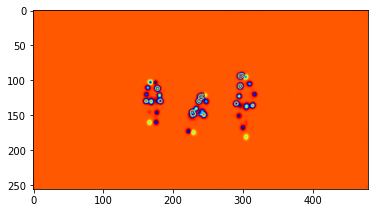

In [38]:
plt.imshow(backtorgb[:,:,::-1])

In [39]:
preds

tensor([[[[-1.2326e+03, -1.2361e+03,  1.4020e+03,  0.0000e+00,  8.1571e-01],
          [-1.3197e+03, -1.2428e+03,  1.5750e+03,  0.0000e+00,  8.1571e-01],
          [-1.2048e+03, -1.2958e+03,  9.2080e+02,  0.0000e+00,  8.1571e-01],
          [-1.1884e+03, -1.3321e+03,  1.4402e+03,  0.0000e+00,  8.1571e-01],
          [-1.2489e+03, -1.4804e+03,  1.1861e+03,  0.0000e+00,  8.1571e-01],
          [-1.2195e+03, -1.4965e+03,  9.8609e+02,  0.0000e+00,  8.1571e-01],
          [-1.2099e+03, -1.3755e+03,  9.2131e+02,  0.0000e+00,  8.1571e-01],
          [-1.2875e+03, -1.4392e+03,  5.3383e+02,  0.0000e+00,  8.1571e-01],
          [-1.2238e+03, -1.4709e+03,  1.6981e+02,  0.0000e+00,  8.1571e-01],
          [-1.1735e+03, -1.1307e+03,  1.3918e+03,  0.0000e+00,  8.1571e-01],
          [-1.1494e+03, -1.0774e+03,  1.1667e+03,  0.0000e+00,  8.1571e-01],
          [-1.2192e+03, -1.0551e+03,  9.2894e+02,  0.0000e+00,  8.1571e-01],
          [-1.1774e+03, -1.1913e+03,  9.3308e+02,  0.0000e+00,  8.1571e-01],

In [40]:
# pixel std is 200.0
x = 0
y = 0
w = 960
h = 512

w = 1920
h = 1080

# w = 512
# h = 512

# input_size = cfg.data_cfg['image_size']
# aspect_ratio = input_size[0] / input_size[1]
# aspect_ratio = 288 / 384
center = np.array([x + w * 0.5, y + h * 0.5], dtype=np.float32)

# if w > aspect_ratio * h:
#     h = w * 1.0 / aspect_ratio
# elif w < aspect_ratio * h:
#     w = h * aspect_ratio

scale = np.array([w / 200.0, h / 200.0], dtype=np.float32)
# scale = scale * 1.25

# scale = np.array([max(w / 200.0, h / 200.0), max(w / 200.0, h / 200.0)], dtype=np.float32)

batch_scale = np.zeros((heatmaps[0].shape[0], 2))
batch_center = np.zeros((heatmaps[0].shape[0], 2))
batch_scale[:] = scale
batch_center[:] = center

In [41]:
reds, maxvals = keypoints_from_heatmaps(heatmaps[camera_i].detach().cpu().numpy(), center=batch_center, scale=batch_scale)

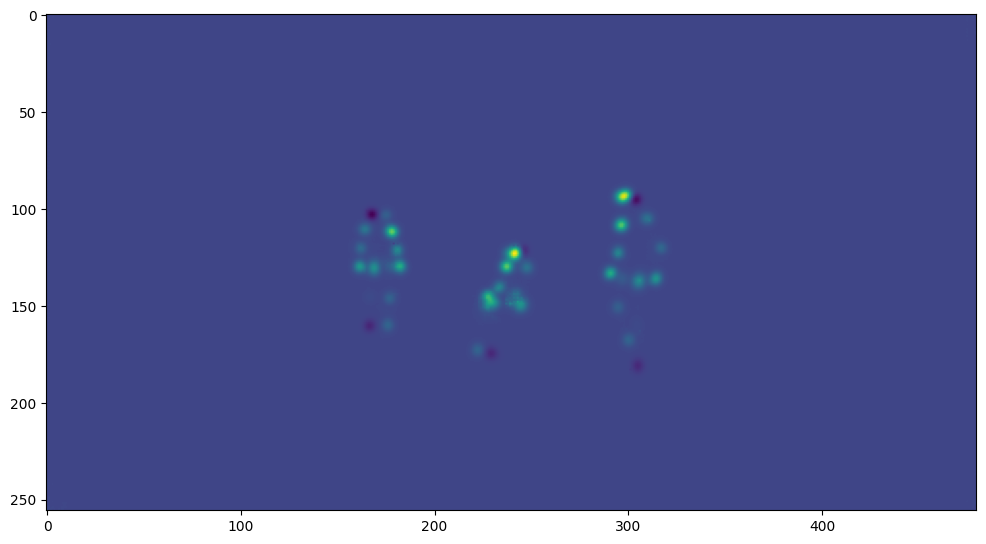

In [42]:
heatmap_fig = np.sum(heatmaps[camera_i][0].detach().cpu().numpy(), axis=0)
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(heatmap_fig)

In [43]:
# preds

In [44]:
# import math
# import matplotlib.pyplot as plt
# import cv2
# import numpy as np
# %matplotlib inline

In [45]:
target_batch_idx = 0

preds_np = preds.detach().cpu().numpy()
one_pred = preds_np[target_batch_idx]
detected_idx = one_pred[:, 0, 3] == 0
num_detected = sum(detected_idx)
print('num_detected is : {}'.format(num_detected))

pred_joint_color = [0, 0, 255]
GT_joint_color = [0, 255, 0]

image_cam = cv2.imread(meta_new[camera_i]['image'][0])

for cand in range(num_detected):
    joint_3d = one_pred[cand, :, :3]
#     joint_3d /= 1000.
    
    ones = np.ones((joint_3d.shape[0],1))
    joint_3d_homo = np.concatenate((joint_3d, ones), axis=1)
    
    P = get_P(meta_new, camera_i, target_batch_idx) # meta, cam_idx, batch_idx , [3,4]
    
    projected = np.matmul(P, joint_3d_homo.T).T
    projected /= projected[:,2:3]

    for joint in range(joint_3d.shape[0]):
        image_cam = cv2.circle(image_cam, (int(projected[joint,0]),int(projected[joint,1])), 0, pred_joint_color, 10)

    
    

num_detected is : 2


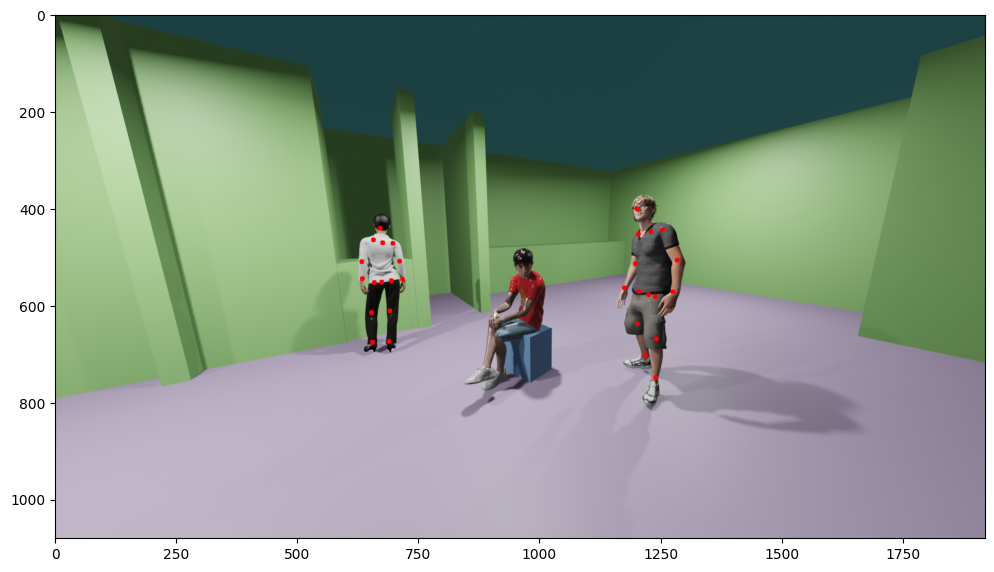

In [46]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(image_cam[:,:,::-1])

In [47]:
# panoptic
LIMBS15 = [[0, 1], [0, 2], [0, 3], [3, 4], [4, 5], [0, 9], [9, 10],
         [10, 11], [2, 6], [2, 12], [6, 7], [7, 8], [12, 13], [13, 14]]

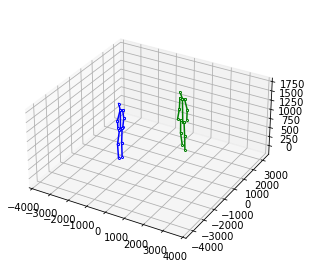

In [48]:
# preds = preds.cpu().numpy()
batch_size = meta_new[0]['num_person'].shape[0]
xplot = min(4, batch_size)
yplot = int(math.ceil(float(batch_size) / xplot))

width = 4.0 * xplot * 2
height = 4.0 * yplot
fig = plt.figure(0, figsize=(width, height))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05,
                    top=0.95, wspace=0.05, hspace=0.15)


space_size = config.MULTI_PERSON.SPACE_SIZE
sapce_center = config.MULTI_PERSON.SPACE_CENTER


for i in range(batch_size):
    num_person = num_detected
#     joints_3d = meta[0]['joints_3d'][i]
#     joints_3d_vis = meta[0]['joints_3d_vis'][i]
    ax = plt.subplot(yplot, xplot, i + 1, projection='3d')
    ax.set_box_aspect(aspect = (2,2,1))
    ax.set_xlim([int(sapce_center[0] - space_size[0]/2), int(sapce_center[0] + space_size[0]/2)])
    ax.set_ylim([int(sapce_center[1] - space_size[1]/2), int(sapce_center[1] + space_size[1]/2)])
    ax.set_zlim([int(sapce_center[2] - space_size[2]/2), int(sapce_center[2] + space_size[2]/2)])
    
#     for n in range(num_person):
#         joint = joints_3d[n]
#         joint_vis = joints_3d_vis[n]
#         for k in eval("LIMBS{}".format(len(joint))):
#             if joint_vis[k[0], 0] and joint_vis[k[1], 0]:
#                 x = [float(joint[k[0], 0]), float(joint[k[1], 0])]
#                 y = [float(joint[k[0], 1]), float(joint[k[1], 1])]
#                 z = [float(joint[k[0], 2]), float(joint[k[1], 2])]
#                 ax.plot(x, y, z, c='r', lw=1.5, marker='o', markerfacecolor='w', markersize=2,
#                         markeredgewidth=1)
#             else:
#                 x = [float(joint[k[0], 0]), float(joint[k[1], 0])]
#                 y = [float(joint[k[0], 1]), float(joint[k[1], 1])]
#                 z = [float(joint[k[0], 2]), float(joint[k[1], 2])]
#                 ax.plot(x, y, z, c='r', ls='--', lw=1.5, marker='o', markerfacecolor='w', markersize=2,
#                         markeredgewidth=1)

    colors = ['b', 'g', 'c', 'y', 'm', 'orange', 'pink', 'royalblue', 'lightgreen', 'gold']
    if preds is not None:
        pred = preds[i]
        for n in range(len(pred)):
            joint = pred[n]
            if joint[0, 3] >= 0:
                for k in eval("LIMBS{}".format(len(joint))):
                    x = [float(joint[k[0], 0]), float(joint[k[1], 0])]
                    y = [float(joint[k[0], 1]), float(joint[k[1], 1])]
                    z = [float(joint[k[0], 2]), float(joint[k[1], 2])]
                    ax.plot(x, y, z, c=colors[int(n % 10)], lw=1.5, marker='o', markerfacecolor='w', markersize=2,
                            markeredgewidth=1)
                                      



In [49]:
pred

tensor([[[-1.2326e+03, -1.2361e+03,  1.4020e+03,  0.0000e+00,  8.1571e-01],
         [-1.3197e+03, -1.2428e+03,  1.5750e+03,  0.0000e+00,  8.1571e-01],
         [-1.2048e+03, -1.2958e+03,  9.2080e+02,  0.0000e+00,  8.1571e-01],
         [-1.1884e+03, -1.3321e+03,  1.4402e+03,  0.0000e+00,  8.1571e-01],
         [-1.2489e+03, -1.4804e+03,  1.1861e+03,  0.0000e+00,  8.1571e-01],
         [-1.2195e+03, -1.4965e+03,  9.8609e+02,  0.0000e+00,  8.1571e-01],
         [-1.2099e+03, -1.3755e+03,  9.2131e+02,  0.0000e+00,  8.1571e-01],
         [-1.2875e+03, -1.4392e+03,  5.3383e+02,  0.0000e+00,  8.1571e-01],
         [-1.2238e+03, -1.4709e+03,  1.6981e+02,  0.0000e+00,  8.1571e-01],
         [-1.1735e+03, -1.1307e+03,  1.3918e+03,  0.0000e+00,  8.1571e-01],
         [-1.1494e+03, -1.0774e+03,  1.1667e+03,  0.0000e+00,  8.1571e-01],
         [-1.2192e+03, -1.0551e+03,  9.2894e+02,  0.0000e+00,  8.1571e-01],
         [-1.1774e+03, -1.1913e+03,  9.3308e+02,  0.0000e+00,  8.1571e-01],
         [-1

In [50]:

# EXPERIMENT that : revealed the pre-trained resnet50 has different final_layer dimension.
# so, final_layer parameter included training optimizer. good.

# pretrained = '/workspace/voxelpose-pytorch/models/pose_resnet50_panoptic.pth.tar'
# if os.path.isfile(pretrained):
#     pretrained_state_dict = torch.load(pretrained)
    
# pretrained_state_list = []
# for param_tensor in pretrained_state_dict:
#     pretrained_state_list.append(param_tensor)
#     print(param_tensor, "\t", pretrained_state_dict[param_tensor].size())
    
# model_state_dict = model.module.backbone.state_dict()

# model_state_dict_list = []
# for param_tensor in model_state_dict:
#     model_state_dict_list.append(param_tensor)
#     print(param_tensor, "\t", model_state_dict[param_tensor].size())
    
# print(len(pretrained_state_list))
# print(len(model_state_dict_list))

# for i in range(338):

#     if pretrained_state_list[i] != model_state_dict_list[i]:
#         print(pretrained_state_list[i])
#         print(model_state_dict_list[i])
        
#     if model_state_dict[pretrained_state_list[i]].size() != pretrained_state_dict[pretrained_state_list[i]].size():
#         print(pretrained_state_list[i])
#         print(pretrained_state_dict[pretrained_state_list[i]].size())
#         print(model_state_dict[pretrained_state_list[i]].size())
        
# model_state_dict[pretrained_state_list[0]].size()
# pretrained_state_dict[pretrained_state_list[0]].size()

# for k, v in pretrained_state_dict.items():
#     if "final_layer" in k:
#         pretrained_state_dict[k] = torch.zeros_like(model_state_dict[k])
# model.module.backbone.load_state_dict(pretrained_state_dict, strict=False)

# for name, param in model.module.backbone.final_layer.named_parameters():
#     print(name)